<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.981 · TFM Àrea 4 · NLP & Text Mining</p>
<p style="margin: 0; text-align:right;">2022 · Màster universitari en Ciència de dades (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudis d'Informàtica, Multimèdia i Telecomunicació</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

<div class="row" style="padding-top: 50px;">
    <div class="row" style="background: #494949;padding: 10px 20px; color: #FFF">
        <div class="col-md-12">
            <div style="text-align:left;"><b>Estudiant:</b> Albert Cámara Viñals</div>
        </div>
    </div>
</div>

## T9 - Information Extraction from *synthetic invoice* with *GraphSage* model (inference)

## **Information extraction**

> Information extraction (IE) is the task of automatically extracting structured information from unstructured and/or semi-structured machine-readable documents and other electronically represented sources. In most of the cases this activity concerns processing images by means computer vision (CV) and processing human language texts by means of natural language processing (NLP).

In [1]:
# Load libraries
import cv2
import glob
import json
import pandas as pd
import pickle
import math
import networkx as nx
import numpy as np
import os
import re
import seaborn as sns
import shutil

from stellargraph import StellarGraph as sg
from stellargraph import globalvar
from stellargraph import utils
from stellargraph.mapper import GraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE

from IPython import display
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw, ImageFont, ImageColor
from sklearn import preprocessing
from xml.etree import ElementTree as ET
from bpemb import BPEmb

multibpemb = BPEmb(lang="multi", vs=320000, dim=300)

plt.style.use("ggplot")

%matplotlib inline

## Data Objects

### Define some data models

In [2]:
# Class to store data attributes of Terms
class Term:
    def __init__(self, record):
        self.src = record.src
        self.num_pages = record.num_pages
        self.page_id = record.page_id
        self.page_width = record.page_width
        self.page_height = record.page_height
        self.id = record.id
        self.col = record.col
        self.row = record.row
        self.width = record.width
        self.height = record.height
        self.x1 = record.x1
        self.y1 = record.y1
        self.x2 = record.x2
        self.y2 = record.y2
        self.x3 = record.x3
        self.y3 = record.y3
        self.x4 = record.x4
        self.y4 = record.y4
        self.rdt = None 
        self.rdr = None
        self.rdb = None
        self.rdl = None
        self.content = record.contents
        self.content_masked = record.contents_masked
        self.correctclass = record.correctclass
        self.tag = record.tag
        self.description = record.description
    
    def set_rdt(self, rdt):
        self.rdt = rdt
        
    def get_rdt(self):
        return self.rdt
    
    def set_rdr(self, rdr):
        self.rdr = rdr
        
    def get_rdr(self):
        return self.rdr
    
    def set_rdb(self, rdb):
        self.rdb = rdb
        
    def get_rdb(self):
        return self.rdb
    
    def set_rdl(self, rdl):
        self.rdl = rdl
        
    def get_rdl(self):
        return self.rdl
     
    def show_term(self):
        print(self.src, self.num_pages, self.page_id, self.page_width, self.page_height, self.id, 
              self.col, self.row, self.width, self.height, self.x1, self.x2)
        
    def centroid(self):
        return  (self.x1 + self.width/2, self.y1 + self.height/2)

In [3]:
# Class to store document as a NetworkX
class NetworkData():
    
    def __init__(self, final_connections, G, df):
        self.final_connections = final_connections
        self.G = G
        self.df = df
        
    def get_processed_data(self):
        return self.df
    
    def get_relationships(self):
        return self.final_connections
    
    def get_networkx_graph(self):
        return self.G

In [4]:
class Item:
    
    def __init__(self, bbox, content, tag):
        self.bbox = bbox
        self.content = content
        self.tag = tag

In [5]:
class Invoice:
    
    def __init__(self):
        self.billing_address = None
        self.billing_contact_number = None
        self.billing_name = None
        self.client_number = None
        self.image = None
        self.invoice_date = None
        self.invoice_number = None
        self.order_number = None
        self.payment_mode = None
        self.shipping_address = None
        self.shipping_name = None
        self.supplier_address = None
        self.supplier_contact_number = None
        self.supplier_fax_number = None
        self.supplier_id = None
        self.supplier_name = None
        self.supplier_siret = None
        self.supplier_vat = None
        self.tax_rate = None
        self.total_amount = None
        self.total_tax = None
        self.total_without_tax = None
        self.line_items = None
        
    def set_field(self, field, value):
        if field == 'BILLING_ADDRESS':
            self.billing_address = merge_text(self.billing_address, value)
        elif field == 'BILLING_CONTACT_NUMBER':
            self.billing_contact_number = merge_text(self.billing_contact_number, value)
        elif field == 'BILLING_NAME':
            self.billing_name = merge_text(self.billing_name, value)
        elif field == 'CLIENT_NUMBER': 
            self.client_number = merge_text(self.client_number, value)
        elif field == 'IMAGE':  
            self.image = merge_text(self.image, value)
        elif field == 'INVOICE_DATE':  
            self.invoice_date = merge_text(self.invoice_date, value)
        elif field == 'INVOICE_NUMBER':  
            self.invoice_number = merge_text(self.invoice_number, value)
        elif field == 'ORDER_NUMBER':  
            self.order_number = merge_text(self.order_number, value)
        elif field == 'PAYMENT_MODE':  
            self.payment_mode = merge_text(self.payment_mode, value)
        elif field == 'SHIPPING_ADDRESS':
            self.shipping_address = merge_text(self.shipping_address, value)
        elif field == 'SHIPPING_NAME':
            self.shipping_name = merge_text(self.shipping_name, value)
        elif field == 'SNO':  
            self.sno = merge_text(self.sno, value)
        elif field == 'SUPPLIER_ADDRESS':  
            self.supplier_address = merge_text(self.supplier_address, value)
        elif field == 'SUPPLIER_CONTACT_NUMBER':  
            self.supplier_contact_number = merge_text(self.supplier_contact_number, value)
        elif field == 'SUPPLIER_FAX_NUMBER':  
            self.supplier_fax_number = merge_text(self.supplier_fax_number, value)
        elif field == 'SUPPLIER_ID':  
            self.supplier_id = merge_text(self.supplier_id, value)
        elif field == 'SUPPLIER_NAME':  
            self.supplier_name = merge_text(self.supplier_name, value)
        elif field == 'SUPPLIER_SIRET':  
            self.supplier_siret = merge_text(self.supplier_siret, value)
        elif field == 'SUPPLIER_VAT':  
            self.supplier_vat = merge_text(self.supplier_vat, value)
        elif field == 'TAX_RATE':  
            self.tax_rate = merge_text(self.tax_rate, value)
        elif field == 'TOTAL_AMOUNT':  
            self.total_amount = merge_text(self.total_amount, value)
        elif field == 'TOTAL_TAX':  
            self.total_tax = merge_text(self.total_tax, value)
        elif field == 'TOTAL_WITHOUT_TAX':  
            self.total_without_tax = merge_text(self.total_without_tax, value)
    
    def add_line_items(self, line_items):        
        self.line_items = line_items
    
    def get_json(self):
        return to_json(self)

In [6]:
class InvoiceLine:
    
    def __init__(self, bbox):
        self.bbox = bbox
        self.quantity = None
        self.description = None
        self.unit_price = None
        self.total_price_without_tax = None
        self.total_price_with_tax = None
        self.tax_rate = None
        self.sno = None
        
        
    def set_field(self, field, value):
        if field == 'QUANTITY':
            self.quantity = value
        elif field == 'PRODUCT_DESCRIPTION':
            self.description = value
        elif field == 'UNIT_PRICE':
            self.unit_price = value
        elif field == 'PRODUCT_TOTAL_PRICE_WITHOUT_TAX': 
            self.total_price_without_tax = value
        elif field == 'PRODUCT_TOTAL_PRICE_WITH_TAX': 
            self.total_price_with_tax = value
        elif field == 'TAX_RATE':  
            self.tax_rate = value
        elif field == 'SNO':  
            self.sno = value
    
    def set_bbox(self, bbox):
        self.bbox = bbox
    
    def get_json(self):
        return to_json(self.__dict__)

## Graph Modeling Algorithm

#### Algorithm 1. Line Formattion

In [7]:
## Algorithm 1. Line Formattion

def extract_lines(df):

    # Sort words based on Top coordinate
    # Sort dataframe by top row and top column (0,0) (left, top)
    df.sort_values(by=['row', 'col'], inplace=True, ascending = [True, True])

    terms = {}
    lines = []  
    line = [Term(df.iloc[0])]

    # Form lines as group of words which obeys the following
    for i in range(1, len(df)):

        wa = Term(df.iloc[i - 1])
        wb = Term(df.iloc[i])

        terms[wa.id] = wa
        terms[wb.id] = wb

        wa_top = wa.y1
        wa_bottom = wa.y4

        wb_top = wb.y1
        wb_bottom = wb.y4

        # Form lines as group of words which obeys the following:
        if wa_top <= wb_bottom and wa_bottom >= wb_bottom:
            #print('Word in same line')
            line.extend([wb])

        else:
            #print('New line')
            if line:
                lines.append(line)
                line = [wb]

        if i == len(df)-1:
            lines.append(line)

    #  Sort words in each line based on Left coordinate
    for line in lines:
        line.sort(key=lambda term: term.x1)
    
    return lines, terms

#### Algorithm 2. Graph Modeling Algorithm

In [8]:
def check_terms_in_vertical_projection(c_term, lines, l_idx):
    #print('Search terms in vertical projection of:', c_term.content)
    projection_terms = []
    for i in range(l_idx + 1, len(lines)):
        for term in lines[i]:
            if c_term.x1 < term.x2 and c_term.x2 > term.x1:
                projection_terms.append(term)
    
    return projection_terms

In [9]:
def check_terms_in_horitzontal_projection(c_term, lines, l_idx, t_idx):
    #print('Search terms in horitzontal projection of:', c_term.content)
    projection_terms = []
    for i in range(l_idx, len(lines)):
        if i == l_idx: 
            for j in range(t_idx +1, len(lines[i])):
                term = lines[i][j]
                if c_term.y1 < term.y4 and c_term.y4 > term.y1:
                    projection_terms.append(term)
        else:
            for term in lines[i]:
                if c_term.y1 < term.y4 and c_term.y4 > term.y1 and c_term.x2 < term.x1:
                    projection_terms.append(term)
                    
    return projection_terms

In [10]:
## Algorithm 2. Graph Modeling Algorithm

def extract_relationships(lines, terms):
    
    relationships =  pd.DataFrame(columns=['n1', 'n2', 'direction'])

    # 1: Read words from each line starting from topmost line going towards bottommost line
    for l_idx, line in enumerate(lines):
        # 2: For each word, perform following:
        for t_idx, term in enumerate(line):

            # 2.1 Check words which are in vertical projection with it:
            terms_in_vertical_projection = check_terms_in_vertical_projection(term, lines, l_idx)

            if terms_in_vertical_projection:
                nnv_term = terms_in_vertical_projection[0]
                least_rdl = 1
                least_rdr = 1

                for pv_term in terms_in_vertical_projection: 
                    rdl = (pv_term.x2 - term.x1)/term.page_width
                    rdr = (pv_term.x1 - term.x2)/term.page_width

                    if abs(rdl) <= least_rdl and abs(rdr) <= least_rdr:
                        least_rdl = abs(rdl)
                        least_rdr = abs(rdr)
                        if pv_term.y1 <= nnv_term.y1:
                            nnv_term = pv_term

                if not ((relationships['n2'] == nnv_term.id) & (relationships['direction'] == 'vertical')).any():
                    rdb = (nnv_term.y1 - term.y3)/term.page_height
                    rdt = -rdb
                    term.set_rdb(rdb)
                    nnv_term.set_rdt(rdt)
                    terms.update({term.id: term, nnv_term.id: nnv_term})
                    relationship = {'n1': term.id,'n2': nnv_term.id, 'direction': 'vertical'}
                    relationships = relationships.append(relationship, ignore_index=True)

                #print('Term in vertical projection:', nnv_term.content)

            #print('') 

            terms_in_horitzontal_projection = check_terms_in_horitzontal_projection(term, lines, l_idx, t_idx)

            if terms_in_horitzontal_projection:
                nnh_term = terms_in_horitzontal_projection[0]
                least_rdt = 1
                least_rdb = 1

                for ph_term in terms_in_horitzontal_projection: 
                    rdt = (ph_term.y4 - term.y1)/term.page_height
                    rdb = (ph_term.y1 - term.y4)/term.page_height

                    if abs(rdt) <= least_rdt and abs(rdb) <= least_rdb:
                        least_rdt = abs(rdt)
                        least_rdb = abs(rdb)
                        if ph_term.x1 <= nnh_term.x1:
                            nnh_term = ph_term

                if not ((relationships['n2'] == nnh_term.id) & (relationships['direction'] == 'horitzontal')).any():
                    rdr = (nnh_term.x1 - term.x2)/term.page_width
                    rdl = -rdr
                    term.set_rdr(rdr)
                    nnh_term.set_rdl(rdl)
                    terms.update({term.id: term, nnh_term.id: nnh_term})
                    relationship = {'n1': term.id ,'n2': nnh_term.id, 'direction': 'horitzontal'}
                    relationships = relationships.append(relationship, ignore_index=True)
                    #print('Term in horitzontal projection:', nnh_term.content)

            #print('\n')
    return relationships

## Functions & Utils

**Define some util functions**

In [11]:
def normalize_bbox(x1, y1, x3, y3, width, height):
    bbox = [
        int(1000 * (x1 / width)),
        int(1000 * (y1 / height)),
        int(1000 * (x3 / width)),
        int(1000 * (y3 / height)),
    ]
    
    return bbox

In [12]:
def unnormalize_bbox(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

In [13]:
def hex2rgba_color(hex, alpha=85):
    c = ImageColor.getcolor(hex, "RGBA")
    y = list(c)
    y[3] = alpha
    
    return tuple(y)

In [14]:
def gen_image_predictions(file, df):
    
    image = Image.open(file)
    image = image.convert("RGBA")

    overlay = Image.new('RGBA', image.size, (255,255,255,0))

    draw = ImageDraw.Draw(overlay)
    font = ImageFont.truetype("arial.ttf", size=14)

    for idx, row in df.iterrows():
        bbox = unnormalize_bbox(row['bbox'], image.size[0], image.size[1])

        color = (0, 255, 0, 85) if row['target'] == row['target_predicted'] else (255, 0, 0, 85)

        draw.rectangle(bbox, fill=color, outline=color, width=2)
        draw.text((bbox[0], bbox[1] - 20), text=row['target'], fill='blue', font=font)

    overlayed_image = Image.alpha_composite(image, overlay)    
    
    return overlayed_image

In [15]:
def gen_colored_image_predictions(file, df):
    image = Image.open(file)
    image = image.convert("RGBA")

    overlay = Image.new('RGBA', image.size, (255,255,255,0))

    draw = ImageDraw.Draw(overlay)
    font = ImageFont.truetype("arial.ttf", size=14)

    for idx, row in df.iterrows():
        bbox = unnormalize_bbox(row['bbox'], image.size[0], image.size[1])

        color = hex2rgba_color(label2color[row['target_predicted']])

        draw.rectangle(bbox, fill=color, outline=color, width=2)
        draw.text((bbox[0], bbox[1] - 20), text=row['target_predicted'], fill='blue', font=font)

    overlayed_image = Image.alpha_composite(image, overlay)    

    return overlayed_image

In [16]:
# Function to draw bounding boxes in images
def draw_bouding_boxes(image, data, color):
    image = cv2.imread(image)

    for index, row in data.iterrows():
        cv2.rectangle(image, (row["x1"], row["y1"]), (row["x3"], row["y3"]), color)
           
    return image

# Function to draw bounding boxes and labels in images
def draw_bouding_boxes_and_labels(image, data, color, color_text, thickness, thickness_text):
    image = cv2.imread(image)

    for index, row in data.iterrows():
        cv2.rectangle(image, (row["x1"], row["y1"]), (row["x3"], row["y3"]), color, thickness)
        cv2.putText(image, row['tag'], (row["x1"], row["y1"]), cv2.FONT_HERSHEY_SIMPLEX, 0.4, color_text, thickness_text)
    
    return image

# Function to preview image
def show_image(image):   
    cv2.imshow('image', image)
    cv2.namedWindow("PREVIEW", cv2.WINDOW_NORMAL)   # Create window with freedom of dimensions
    image_resized = cv2.resize(image, (595, 842))   # Resize image
    cv2.imshow("PREVIEW", image_resized)            # Show image
    cv2.waitKey(0)                                  # Display the image infinitely until any keypress
        
def get_overlap_x(n1, n2):
    # overlap 
    x1 = max(n1.x1, n2.x1)
    x2 = min(n1.x2, n2.x2)
    
    return math.floor(x1 + (x2 - x1)/2)
    
def get_overlap_y(n1, n2):
    # overlap 
    y1 = max(n1.y1, n2.y1)
    y3 = min(n1.y3, n2.y3)
    
    return math.floor(y1 + (y3-y1)/2)

# Function to draw term relationships in image
def draw_relationships(image, df, relationships, color, thickness):
    
    data = df.copy()
    data.reset_index(inplace=True)
    data = data.rename(columns = {'index': 'id'})
    data = data.set_index('node_id')
    
    for index, relationship in relationships.iterrows():
        n1_id = relationship['n1']
        n2_id = relationship['n2']
        
        n1 = Term(data.loc[n1_id])
        n2 = Term(data.loc[n2_id])
                
        direction = relationship['direction']
                
        if direction == 'vertical':
            start_point = (get_overlap_x(n1, n2), n1.y3)
            end_point = (get_overlap_x(n1, n2), n2.y1)
            cv2.line(image, start_point, end_point, color, thickness)
        else:
            start_point = (n1.x2, get_overlap_y(n1, n2))
            end_point = (n2.x1, get_overlap_y(n1, n2))
            cv2.line(image, start_point, end_point, color, thickness)
    return image

In [17]:
def to_json(obj):
    return json.dumps(obj, default=lambda obj: obj.__dict__, indent=1, ensure_ascii=False)

def merge_text(text, value):
    return text +  " " + str(value) if text else str(value)

In [18]:
# Generate two text boxes a larger one that covers them
def merge_boxes(box1, box2):
    return [
        min(box1[0], box2[0]), 
        min(box1[1], box2[1]), 
        max(box1[2], box2[2]),
        max(box1[3], box2[3])
    ]

In [19]:
def check_invoice_line_exists(invoice_lines, item):
    for idx, line in enumerate(invoice_lines):
        #print('Check line: ', idx, 'with', item.content, item.tag, item.bbox, line.bbox)
        #print('lt', line.bbox[1], 'lb', line.bbox[3], 'tt', term.bbox[1], 'tb', term.bbox[3])
       
        if line.bbox[1] <= item.bbox[3] and line.bbox[3] >= item.bbox[1]:
            return idx
    
    return -1
    
def extract_invoice_lines(items):
    invoice_lines = []
    
    for item in items:
        
        if item.tag in ['QUANTITY', 'SNO', 'PRODUCT_DESCRIPTION', 'UNIT_PRICE', 'PRODUCT_TOTAL_PRICE_WITHOUT_TAX', 'PRODUCT_TOTAL_PRICE_WITH_TAX', 'TAX_RATE']:
            line_idx = check_invoice_line_exists(invoice_lines, item);
            
            if line_idx != -1:
                bbox = merge_boxes(invoice_lines[line_idx].bbox, item.bbox)
                invoice_lines[line_idx].set_field(item.tag, item.content)
                #invoice_lines[line_idx].set_bbox(bbox)
            else:
                invoice_line = InvoiceLine(item.bbox)
                invoice_line.set_field(item.tag, item.content)
                invoice_lines.append(invoice_line)
                
    return invoice_lines

In [20]:
def convert_extracted_data_to_invoice(df):
    # Extract bbox points
    df['x1'] = df.apply(lambda x: x['bbox'][0], axis=1)
    df['y1'] = df.apply(lambda x: x['bbox'][1], axis=1)
    df['x2'] = df.apply(lambda x: x['bbox'][2], axis=1)
    df['y2'] = df.apply(lambda x: x['bbox'][3], axis=1)

    # Sort words based on Top coordinate
    # Sort dataframe by top row and top column (0,0) (left, top)
    df.sort_values(by=['y1', 'x1'], inplace=True, ascending = [True, True])

    items = []

    term = df.iloc[0]
    item = Item(term['bbox'], term['word'], term['target_predicted'])
    items.append(item)

    for idx in range(1, len(df)):    
        term = df.iloc[idx]
        last_item = items[-1]

        if last_item.tag == term['target_predicted']:
            bbox = merge_boxes(last_item.bbox, term['bbox'])
            text = last_item.content + ' ' + term['word']

            items[-1].bbox = bbox
            items[-1].content= text

            #print('merged', items[-1].content)

        else: 
            item = Item(term['bbox'], term['word'], term['target_predicted'])
            items.append(item)

    # Create an empty invoice
    invoice = Invoice()

    # Add extracted Invoice Fields
    for item in items:    
        if item.tag not in ['OTHER', 'QUANTITY', 'SNO', 'PRODUCT_DESCRIPTION', 'UNIT_PRICE', 'PRODUCT_TOTAL_PRICE_WITHOUT_TAX', 'PRODUCT_TOTAL_PRICE_WITH_TAX', 'TAX_RATE']:
            invoice.set_field(item.tag, item.content)

    invoice_lines = extract_invoice_lines(items)

    invoice.add_line_items(invoice_lines)
    
    return invoice

**Define a function to extract features and relationships of a document**

In [21]:
def process_file_to_get_features_and_relationships(filepath):
    dirname = os.path.dirname(filepath)
    filename = os.path.basename(filepath)
    basename = os.path.splitext(filename)[0]
    
    # Read dataframe
    df = pd.read_csv(filepath, sep=';')

    # Delete rows with null content and reset index
    df = df.dropna()
    df = df.reset_index(drop=True)

    # Create attributes
    df['alphabetic'] = df.apply(lambda x: x['contents_masked'].count('A'), axis=1)
    df['numeric'] = df.apply(lambda x: x['contents_masked'].count('N'), axis=1)
    df['symbolic'] = df.apply(lambda x: x['contents_masked'].count('S'), axis=1)
   
    # Extract Lines
    lines, terms = extract_lines(df)

    # Extraxt relationships
    relationships = extract_relationships(lines, terms)
    
    # Prepend the node IDs that occur in each document with some kind of unique identifier for the specific document.
    df['node_id'] = df.apply(lambda x: basename.replace('-', '').lower() + '_' + str(x['id']), axis=1)
    relationships['n1'] = relationships.apply(lambda x: basename.replace('-', '').lower() + '_' + str(x['n1']), axis=1)
    relationships['n2'] = relationships.apply(lambda x: basename.replace('-', '').lower() + '_' + str(x['n2']), axis=1)
    
    # Update document Dataframe with new attributes
    df = df.set_index('id')

    # Assign new attributes to original dataframe
    for k, v in terms.items():
        df.at[k, 'rdt'] = v.get_rdt()
        df.at[k, 'rdr'] = v.get_rdr()
        df.at[k, 'rdb'] = v.get_rdb()
        df.at[k, 'rdl'] = v.get_rdl()
    
    # Create features
    df['f1'] = df.apply(lambda x: x['row']/x['page_height'], axis=1)
    df['f2'] = df.apply(lambda x: x['col']/x['page_width'], axis=1)
    df['f3'] = df.apply(lambda x: x['width']/x['page_width'], axis=1)
    df['f4'] = df.apply(lambda x: x['height']/x['page_height'], axis=1)
    df['f5'] = df.apply(lambda x: x['alphabetic']/len(x['contents']), axis=1)
    df['f6'] = df.apply(lambda x: x['numeric']/len(x['contents']), axis=1)
    df['f7'] = df.apply(lambda x: x['symbolic']/len(x['contents']), axis=1)
    df['f8'] = df.apply(lambda x: x['rdt'] if not np.isnan(x['rdt']) else 0, axis=1)
    df['f9'] = df.apply(lambda x: x['rdr'] if not np.isnan(x['rdr']) else 0, axis=1)
    df['f10'] = df.apply(lambda x: x['rdb'] if not np.isnan(x['rdb']) else 0, axis=1)
    df['f11'] = df.apply(lambda x: x['rdl'] if not np.isnan(x['rdl']) else 0, axis=1)
    df['f12'] = df.apply(lambda x: generate_bpemb_feature(x['contents'], 300), axis=1)
   
    df['feature'] = df.apply(lambda x: np.concatenate((
        np.array( [ x['f1'], x['f2'], x['f3'], x['f4'], x['f5'], x['f6'], x['f7'], x['f8'], x['f9'], x['f10'], x['f11'] ]), 
        x['f12']), axis=None), axis=1)
    
    # Create Graph
    # Add node relations
    G = nx.from_pandas_edgelist(relationships, "n1", "n2", ["direction"])
    
    # Add node features
    for node_id, node_data in G.nodes(data=True):
        node_data["feature"] = df[df['node_id'] == node_id]['feature'].values[0]

    # Store all info in a Object
    networkobject = NetworkData(relationships, G, df)
    
    return networkobject

In [22]:
def generate_bpemb_feature(text, length):
    emb = np.reshape(multibpemb.embed(text), -1)

    if emb.size < length:
        emb = np.pad(emb, (0, length-emb.size), constant_values=0)
    elif emb.size > length:
        emb = emb[0:length]
    else:
        emb = emb
        
    return emb

**Define work directories**

In [23]:
# Define directories & FileNames
master_data_dir = './data'
data_dir = './data/examples/'
models_dir = './models/'
filename = 'natureDecouvertes-100.csv'
basename = 'natureDecouvertes-100'

**Prepare document for model loading**

In [24]:
# Get features, relationships and NetworkX model of a Document
network = process_file_to_get_features_and_relationships(os.path.join(data_dir, filename))

# Get features of Terms of the document
df = network.get_processed_data()
print('Number of Terms:', len(df))

# Get relationships between Terms of the document
relationships = network.get_relationships()
print('Number of relationships:', len(relationships))

# Get NetworkX Graph of the document
G = network.get_networkx_graph()
labels = {d['node_id']: d['contents'] for d in df.to_dict(orient='records')}
edge_colors = ['red' if G[u][v]['direction'] == 'vertical' else 'green'  for u,v in G.edges]

# Show number of Nodes & Edges
print('Number of Nodes:', G.number_of_nodes())
print('Number of Edges:', G.number_of_edges())

Number of Terms: 162
Number of relationships: 235
Number of Nodes: 162
Number of Edges: 235


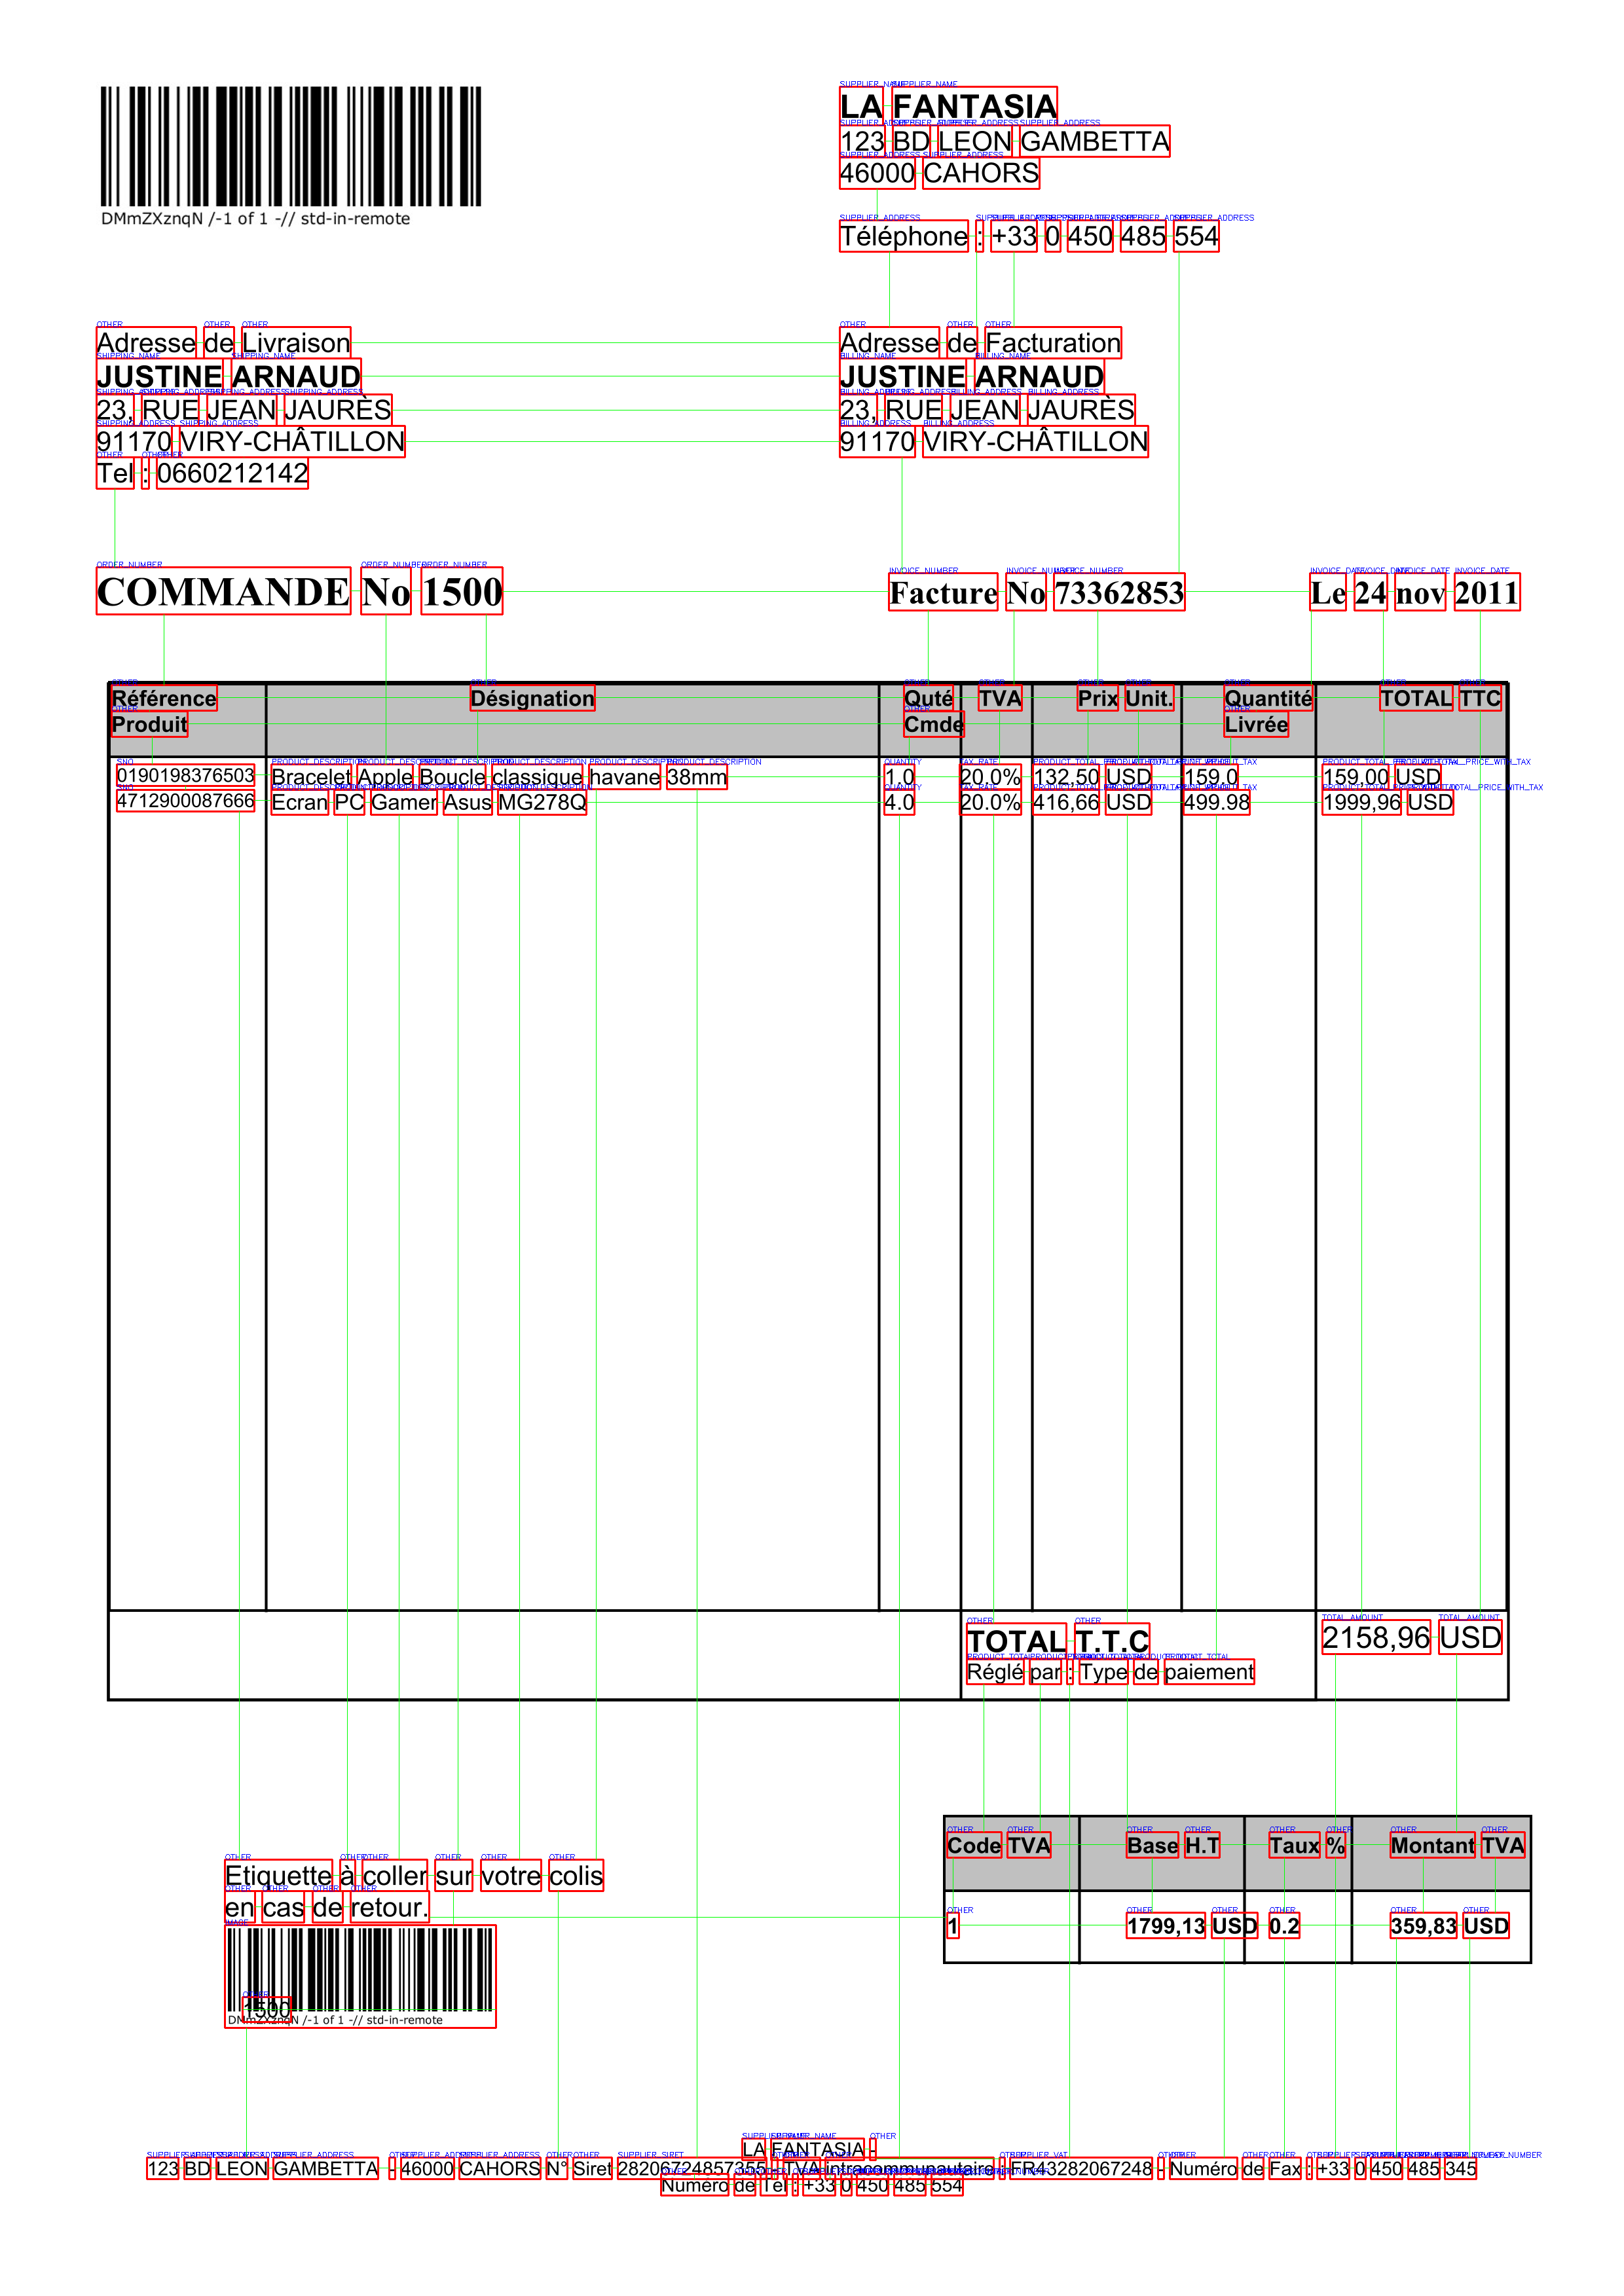

In [25]:
# Draw bounding boxes and labels. Then preview image
image = draw_bouding_boxes_and_labels(os.path.join(data_dir, basename + '.tiff'), df, (0, 0, 255), (255,0, 0), 2, 1)

# Draw relationships
image = draw_relationships(image, df, relationships, (0, 255, 0), 1)

# Write image with bounding boxes, labels and relationships
cv2.imwrite(os.path.join(data_dir, basename + '-relationships.png'), image)

#show_image(image)

display.Image(os.path.join(data_dir, basename + '-relationships.png'))

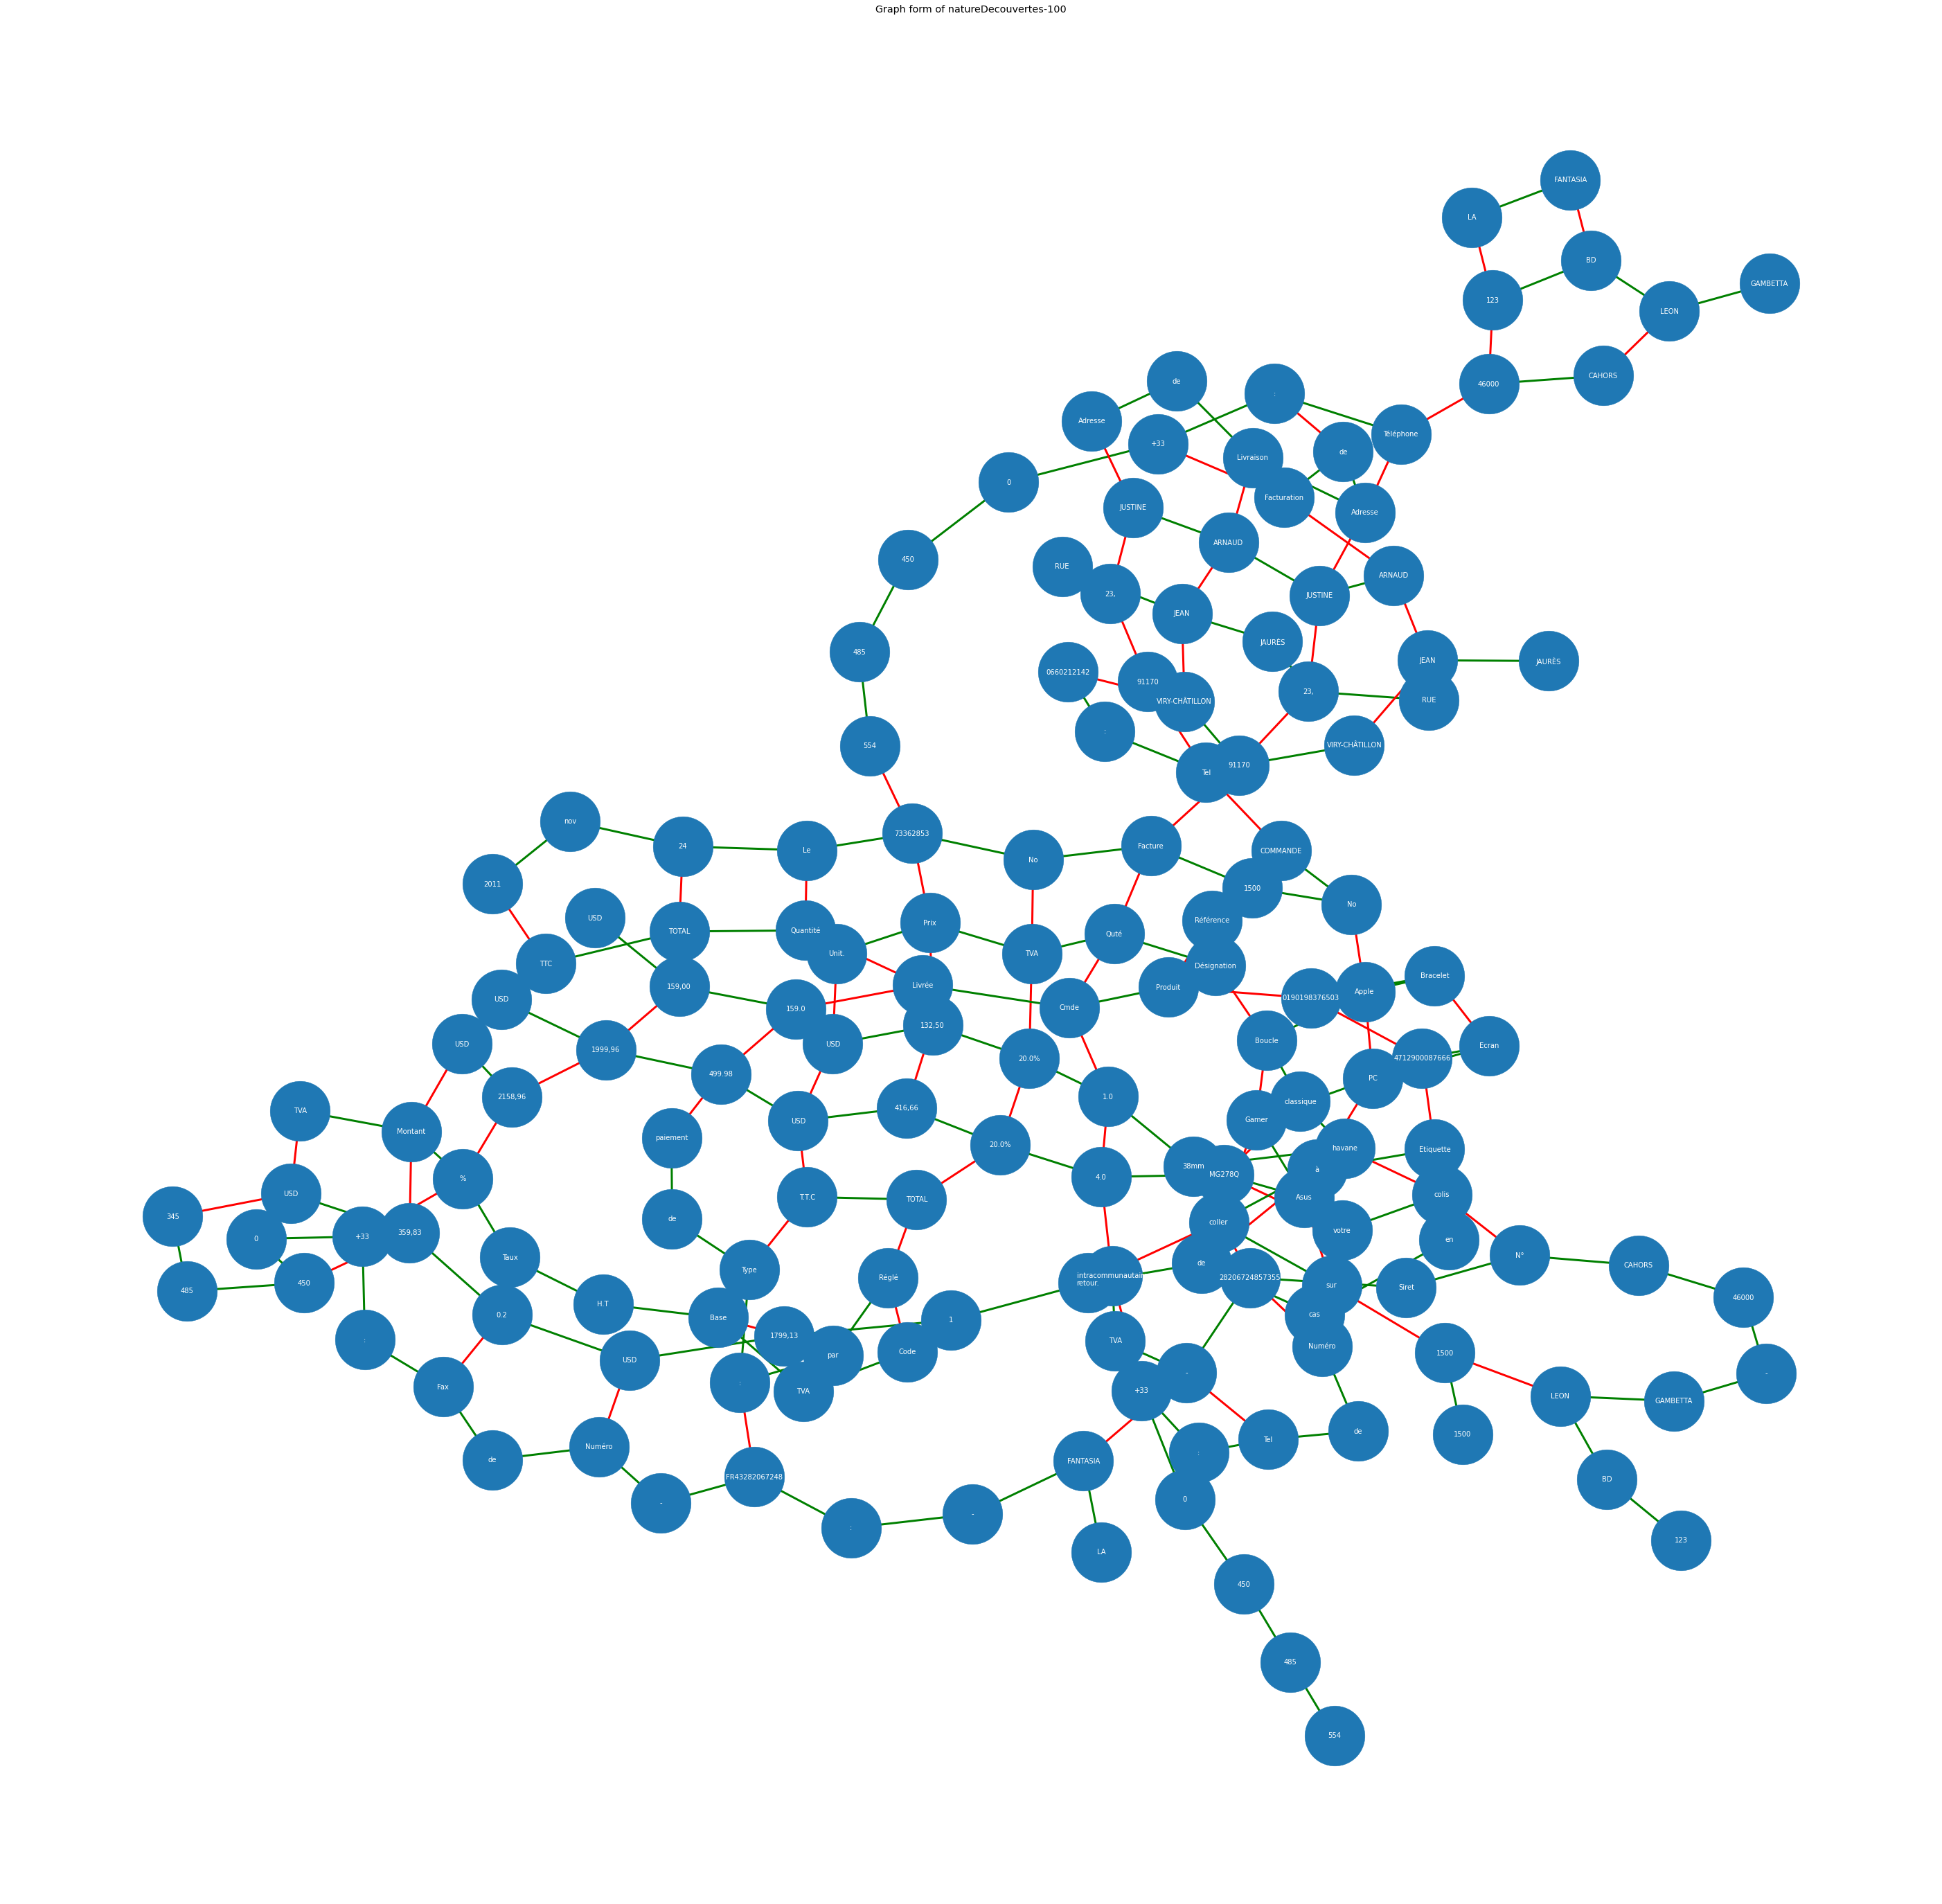

In [26]:
# Preview the graph of the document
layout = nx.kamada_kawai_layout(G)
f = plt.figure(figsize=(50, 50))

ax = plt.gca()
ax.set_title('Graph form of ' + basename)

nx.draw(G, layout, labels=labels, with_labels=True, edge_color=edge_colors, node_size=7500, width=3, alpha=1, font_size=10, font_color="white")
plt.savefig(os.path.join(data_dir, basename + '-graph.jpg'), format="PNG", dpi=f.dpi)

## Making predictions with the model

**Load Model**

In [27]:
from keras.models import load_model
from stellargraph.layer.graphsage import MeanAggregator 

# Load the model
graph_sage_model = load_model(os.path.join(models_dir, 'graph_sage_model.h5'), custom_objects={'MeanAggregator': MeanAggregator})

In [28]:
# Create Document Graph
doc_graph = sg.from_networkx(G, node_features="feature")
print(doc_graph.info())

StellarGraph: Undirected multigraph
 Nodes: 162, Edges: 235

 Node types:
  default: [162]
    Features: float32 vector, length 311
    Edge types: default-default->default

 Edge types:
    default-default->default: [235]
        Weights: all 1 (default)
        Features: none


In [29]:
# Get Document values (node_id, tag)
doc = df.loc[:, ['node_id', 'tag']]
doc.rename(columns = {'tag':'node_target'}, inplace = True)

doc.head(5)

,node_id,node_target
id,,
116866,naturedecouvertes100_116866,SUPPLIER_NAME
116867,naturedecouvertes100_116867,SUPPLIER_NAME
116868,naturedecouvertes100_116868,SUPPLIER_ADDRESS
116869,naturedecouvertes100_116869,SUPPLIER_ADDRESS
116870,naturedecouvertes100_116870,SUPPLIER_ADDRESS


In [30]:
batch_size = 50
num_samples = [10, 10]

# Create a generator function to generate batches of nodes given the Stellar Network Graph.
generator = GraphSAGENodeGenerator(doc_graph, batch_size, num_samples)

**Single prediction** (true inference)

In [31]:
# Make predictions on Document
gen = generator.flow(doc.node_id)
predictions = graph_sage_model.predict(gen)

In [32]:
# Load Target Encoder
target_encoding_file = open(os.path.join(master_data_dir, 'target_encoding.pickle'), "rb")
target_encoding = pickle.load(target_encoding_file)
target_encoding_file.close()

In [33]:
# Convert one-hot-encoding label to Text label
node_predictions = target_encoding.inverse_transform(predictions.squeeze())

doc_pred = pd.DataFrame(columns = ['word', 'bbox', 'target', 'target_predicted'])

doc_pred['word'] = df[['contents']].copy()
doc_pred['bbox'] = df.apply((lambda x: normalize_bbox(x['x1'], x['y1'], x['x3'], x['y3'], x['page_width'], x['page_height'])), axis=1).values
doc_pred['target'] = doc.loc[:, ['node_target']]
doc_pred['target_predicted'] = node_predictions

# Preview dataframe
doc_pred.head(10)

,word,bbox,target,target_predicted
id,,,,
116866,LA,"[516, 37, 543, 54]",SUPPLIER_NAME,SUPPLIER_ADDRESS
116867,FANTASIA,"[549, 37, 650, 54]",SUPPLIER_NAME,SUPPLIER_ADDRESS
116868,123,"[516, 54, 544, 68]",SUPPLIER_ADDRESS,SUPPLIER_ADDRESS
116869,BD,"[549, 54, 572, 68]",SUPPLIER_ADDRESS,SUPPLIER_ADDRESS
116870,LEON,"[577, 54, 622, 68]",SUPPLIER_ADDRESS,SUPPLIER_ADDRESS
116871,GAMBETTA,"[627, 54, 720, 68]",SUPPLIER_ADDRESS,SUPPLIER_NAME
116872,46000,"[516, 68, 563, 82]",SUPPLIER_ADDRESS,SUPPLIER_ADDRESS
116873,CAHORS,"[568, 68, 639, 82]",SUPPLIER_ADDRESS,SUPPLIER_ADDRESS
116874,Téléphone,"[516, 95, 595, 109]",SUPPLIER_ADDRESS,SUPPLIER_ADDRESS


## Preview predicted Fields

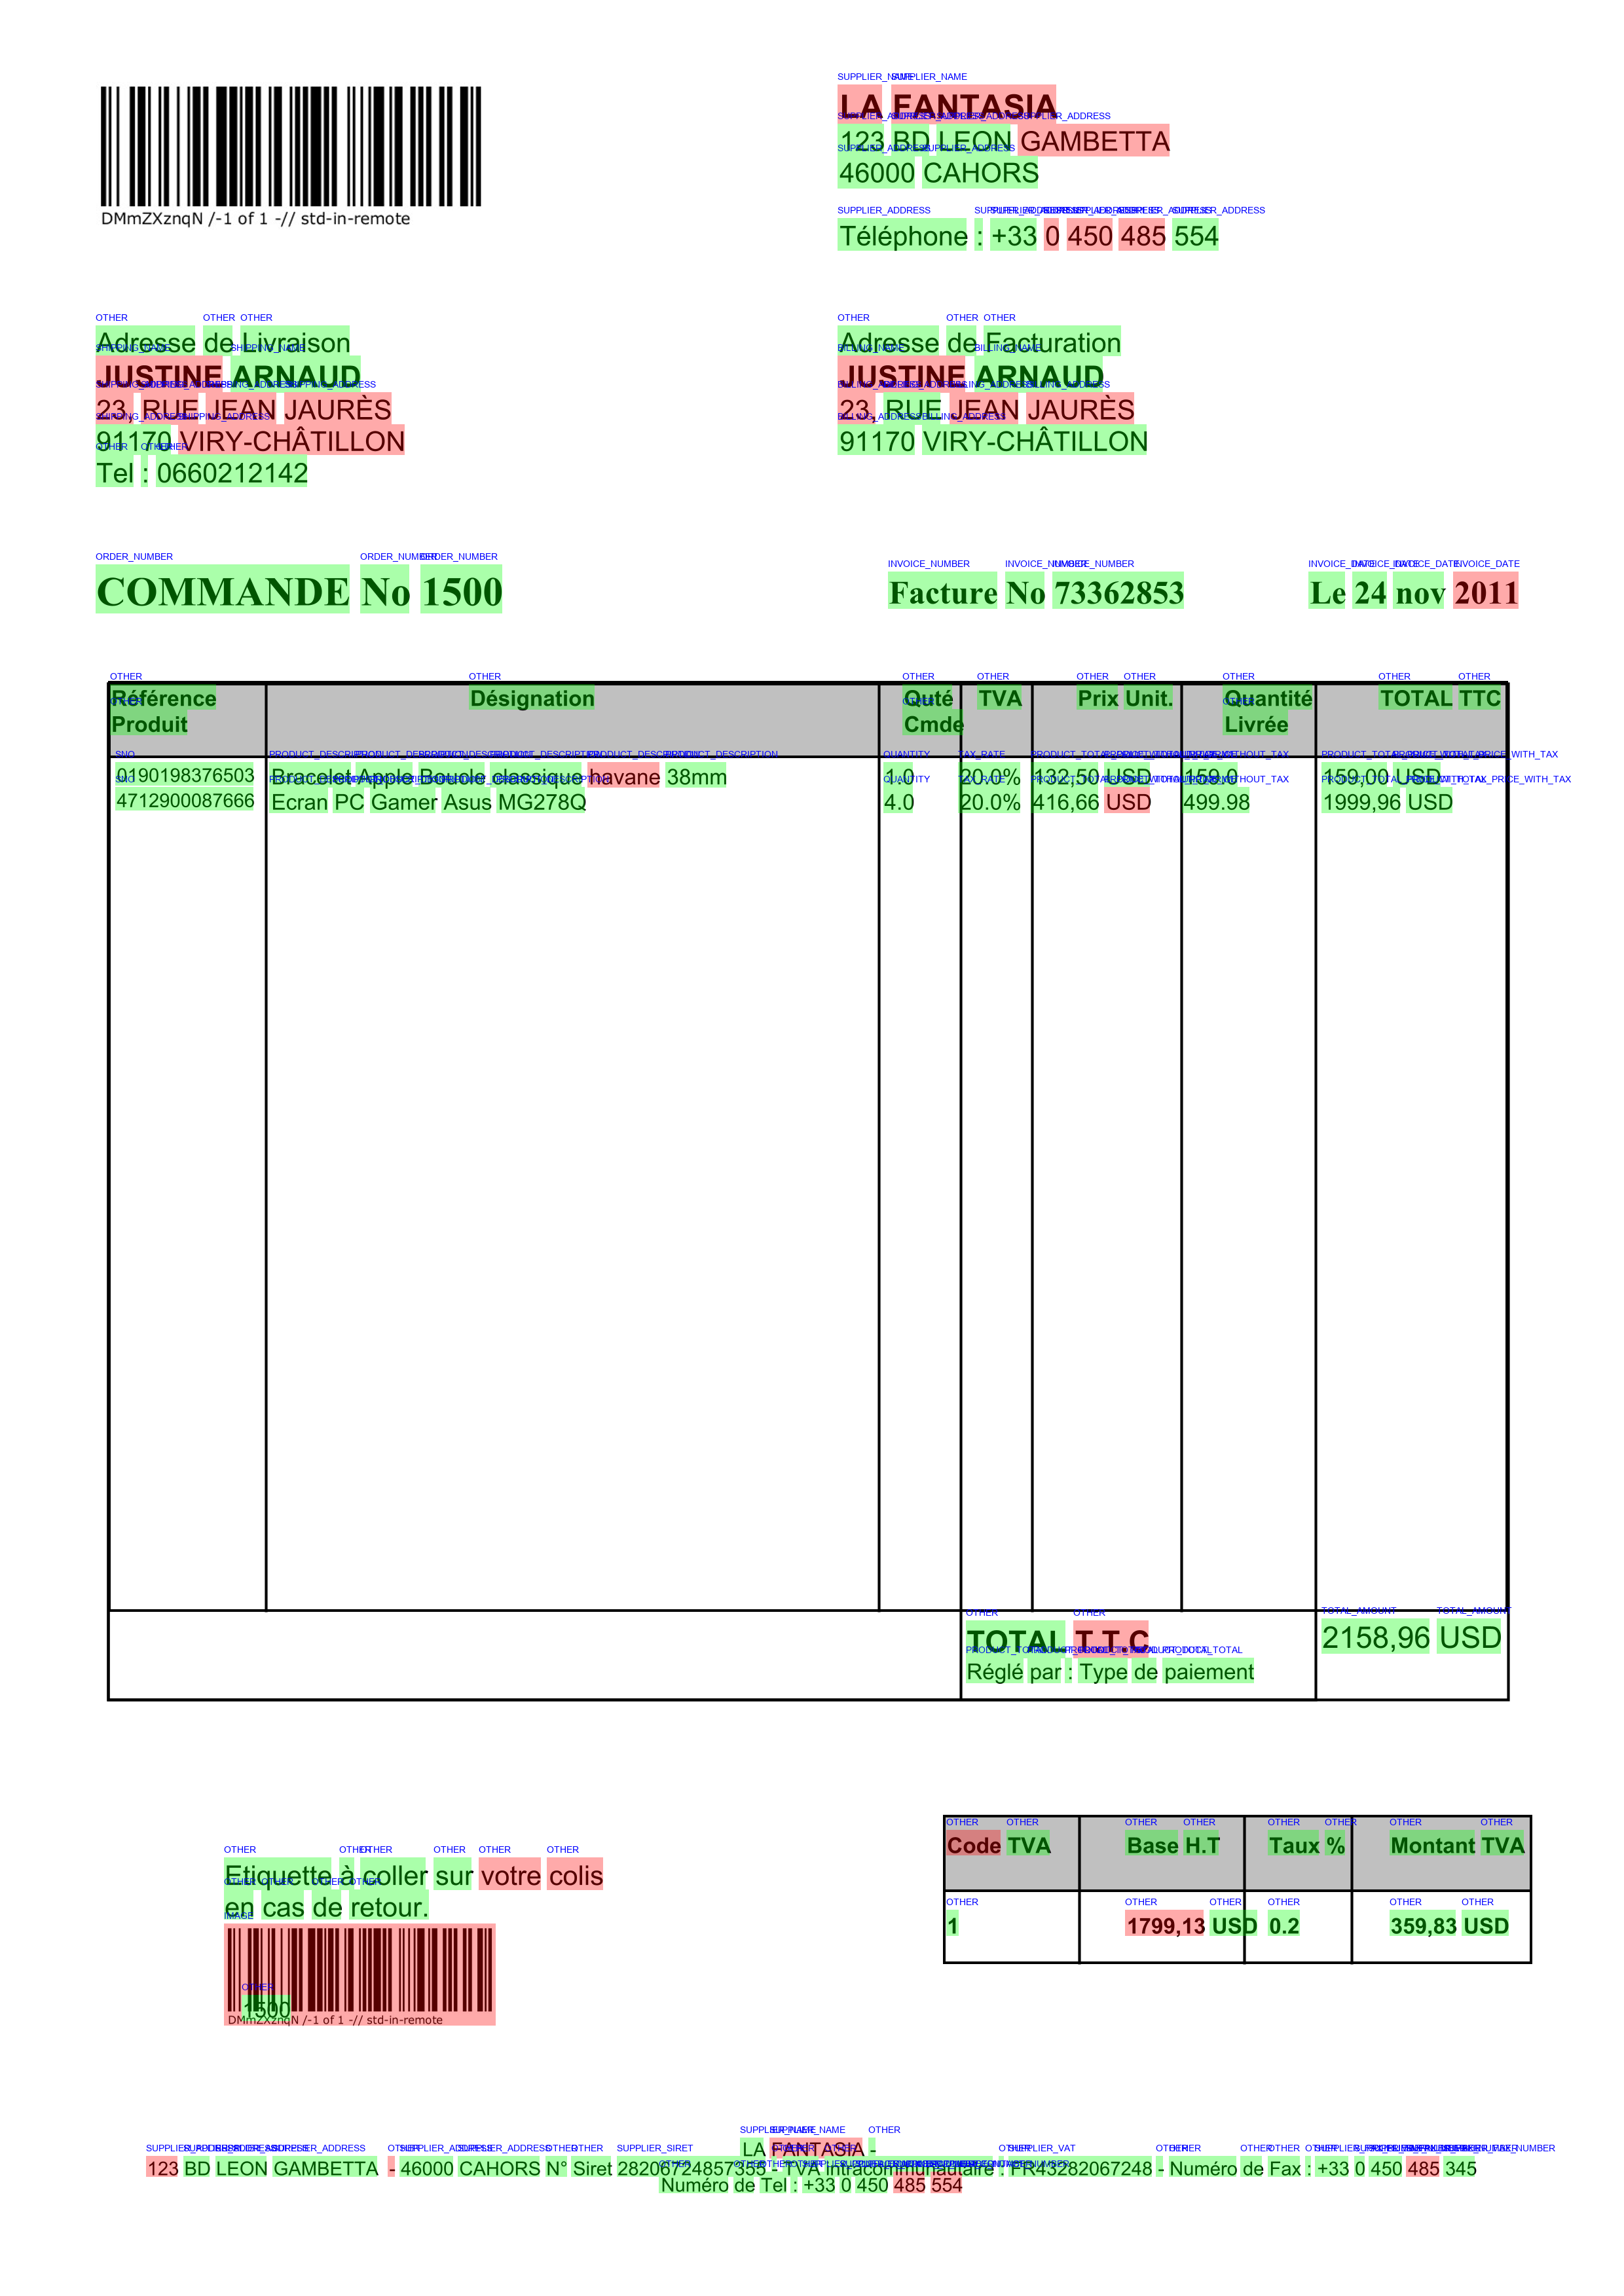

In [34]:
# Show predictions
overlayed_image = gen_image_predictions(os.path.join(data_dir, basename + '.tiff'), doc_pred)

overlayed_image

## Extracted Information

In [35]:
invoice = convert_extracted_data_to_invoice(doc_pred)

print('Invoice: \n')
print(invoice.get_json())

Invoice: 

{
 "billing_address": "23, RUE JEAN JAURÈS RUE 91170 VIRY-CHÂTILLON",
 "billing_contact_number": null,
 "billing_name": "JUSTINE ARNAUD",
 "client_number": null,
 "image": null,
 "invoice_date": "Le 24 nov 1500",
 "invoice_number": "Facture No 73362853",
 "order_number": "COMMANDE No 1500",
 "payment_mode": null,
 "shipping_address": "23, JEAN JAURÈS 91170",
 "shipping_name": "ARNAUD JUSTINE",
 "supplier_address": "LA FANTASIA 123 BD LEON 46000 CAHORS Téléphone : +33 554 VIRY-CHÂTILLON havane colis FANTASIA BD LEON GAMBETTA - 46000 CAHORS",
 "supplier_contact_number": "0 450 +33 0 450",
 "supplier_fax_number": "+33 0 450 345",
 "supplier_id": null,
 "supplier_name": "GAMBETTA LA",
 "supplier_siret": "28206724857355",
 "supplier_vat": "485 123 FR43282067248 485 485 554",
 "tax_rate": null,
 "total_amount": "2158,96 USD",
 "total_tax": "1799,13",
 "total_without_tax": null,
 "line_items": [
  {
   "bbox": [
    71,
    332,
    156,
    342
   ],
   "quantity": "1.0",
   "desc